In [3]:
!pip install numpy scikit-learn pandas

     |████████████████████████████████| 11.3 MB 12.5 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 14.7 MB/s eta 0:00:01


In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [304]:
import torch.nn as nn
from torchvision import transforms
import torch.utils.data.dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from losses import compute_contrastive_loss_from_feats
from utils import *  # bad practice, nvm
from models import *

ckpt_dir = 'exp_data'

In [286]:
from dataset import ImageDataset
from training_config import doodles, reals, doodle_size, real_size, NUM_CLASSES

train_set = ImageDataset(doodles, reals, doodle_size, real_size, train=True)
val_set = ImageDataset(doodles, reals, doodle_size, real_size, train=False)

Train = True. Doodle list: ['sketchy_doodle', 'tuberlin', 'google_doodles'], 
 real list: ['sketchy_real', 'google_real', 'cifar']. 
 classes: dict_keys(['airplane', 'car', 'cat', 'dog', 'frog', 'horse', 'truck', 'bird', 'ship']) 
Doodle data size 7022, real data size 46364, ratio 0.15145371408851696
Train = False. Doodle list: ['sketchy_doodle', 'tuberlin', 'google_doodles'], 
 real list: ['sketchy_real', 'google_real', 'cifar']. 
 classes: dict_keys(['airplane', 'car', 'cat', 'dog', 'frog', 'horse', 'truck', 'bird', 'ship']) 
Doodle data size 1764, real data size 9341, ratio 0.18884487742211756


In [287]:
val_loader = DataLoader(val_set, batch_size=512, shuffle=False, drop_last=True)

In [288]:
def convbn(in_channels, out_channels, kernel_size, stride, padding, bias):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class V2ConvNet(nn.Module):
    CHANNELS = [64, 128, 192, 256, 512]
    POOL = (1, 1)

    def __init__(self, in_c, num_classes, dropout=0.2, add_layers=False):
        super().__init__()
        layer1 = convbn(in_c, self.CHANNELS[1], kernel_size=3, stride=2, padding=1, bias=True)
        layer2 = convbn(self.CHANNELS[1], self.CHANNELS[2], kernel_size=3, stride=2, padding=1, bias=True)
        layer3 = convbn(self.CHANNELS[2], self.CHANNELS[3], kernel_size=3, stride=2, padding=1, bias=True)
        layer4 = convbn(self.CHANNELS[3], self.CHANNELS[4], kernel_size=3, stride=2, padding=1, bias=True)
        pool = nn.AdaptiveAvgPool2d(self.POOL)
#         self.layers = nn.Sequential(layer1, layer2, layer3, layer4, pool)

#         if add_layers:
        layer1_2 = convbn(self.CHANNELS[1], self.CHANNELS[1], kernel_size=3, stride=1, padding=0, bias=True)
        layer2_2 = convbn(self.CHANNELS[2], self.CHANNELS[2], kernel_size=3, stride=1, padding=0, bias=True)
        layer3_2 = convbn(self.CHANNELS[3], self.CHANNELS[3], kernel_size=3, stride=1, padding=0, bias=True)
        layer4_2 = convbn(self.CHANNELS[4], self.CHANNELS[4], kernel_size=3, stride=1, padding=0, bias=True)
        self.layers = nn.Sequential(layer1, layer1_2, layer2, layer2_2, layer3, layer3_2, layer4, layer4_2, pool)

        self.nn = nn.Linear(self.POOL[0] * self.POOL[1] * self.CHANNELS[4], num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, return_feats=False):
        feats = self.layers(x).flatten(1)
        x = self.nn(self.dropout(feats))

        if return_feats:
            return x, feats

        return x

In [289]:
doodle_model = V2ConvNet(1, NUM_CLASSES, dropout=0.2)
real_model = V2ConvNet(3, NUM_CLASSES, dropout=0.2)

In [290]:
model1 = load_model_dic(doodle_model, "v2cnn_trained/24_model1.pt")
model2 = load_model_dic(real_model, "v2cnn_trained/24_model2.pt")

Model loaded: v2cnn_trained/24_model1.pt
Model loaded: v2cnn_trained/24_model2.pt


In [316]:
print (model2(torch.rand(1, 3, 64, 64)).shape)

torch.Size([1, 9])


In [291]:
model1.eval(), model1.eval()
running_loss1 = 0.0
running_loss2 = 0.0
for i, (x1, y1, x2, y2) in enumerate(val_loader):
    pred1, feats1 = model1(x1, return_feats=True)
    pred2, feats2 = model2(x2, return_feats=True)
    running_loss1 += compute_accuracy(pred1, y1)
    running_loss2 += compute_accuracy(pred2, y2)
avg_loss1 = running_loss1 / (i + 1)
avg_loss2 = running_loss2 / (i + 1)
print(f"Doodle val acc: {avg_loss1:.4f}, Real val acc: {avg_loss2:.4f}")

Doodle val acc: 0.6433, Real val acc: 0.7183


In [293]:
nb_classes = 9

confusion_matrix1 = torch.zeros(nb_classes, nb_classes)
confusion_matrix2 = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (x1, y1, x2, y2) in enumerate(val_loader):
        pred1, feats1 = model1(x1, return_feats=True)
        pred2, feats2 = model2(x2, return_feats=True)
        _, preds1 = torch.max(pred1, 1)
        _, preds2 = torch.max(pred2, 1)
        for t, p in zip(y1.view(-1), preds1.view(-1)):
            confusion_matrix1[t.long(), p.long()] += 1
        for t, p in zip(y2.view(-1), preds2.view(-1)):
            confusion_matrix2[t.long(), p.long()] += 1

class_wise_scores_md1 = confusion_matrix1.diag()/confusion_matrix1.sum(1)
class_wise_scores_md2 = confusion_matrix2.diag()/confusion_matrix2.sum(1)

In [294]:
classes = ["airplane", "car", "cat", "dog", "frog", "horse", "truck", "bird", "ship"]

print ("Class-wise validation accuracy with V2 ConvNet:")
print ("{:^12}|{:^12}|{:^10}".format("Class", "Doodle Acc", "Real Acc"))
print ("--" * 17)
for i in range(len(classes)):
    print ("{:^12}|{:^12.3f}|{:^10.3f}".format(classes[i], class_wise_scores_md1[i], class_wise_scores_md2[i]))

Class-wise validation accuracy with V2 ConvNet:
   Class    | Doodle Acc | Real Acc 
----------------------------------
  airplane  |   0.735    |  0.823   
    car     |   0.682    |  0.109   
    cat     |   0.594    |  0.658   
    dog     |   0.500    |  0.692   
    frog    |   0.636    |  0.843   
   horse    |   0.748    |  0.860   
   truck    |   0.668    |  0.863   
    bird    |   0.672    |  0.721   
    ship    |   0.595    |  0.890   


In [305]:
def get_CAM(feature_map, weight, class_idx):
    size_upsample = (64, 64)
    bz, nc, h, w = feature_map.shape

    before_dot = feature_map.reshape((nc, h*w))
    cam = weight[class_idx].unsqueeze(0) @ before_dot

    cam = cam.squeeze(0)
    cam = cam.reshape(h, w)
    cam = cam - torch.min(cam)
    cam = cam / torch.max(cam)
    cam = torch.clip(cam, 0, 1)
    
    img = transforms.Resize(size_upsample)(cam.unsqueeze(0))
    
    return img.detach().numpy(), cam

In [322]:
def plot_cam(img, cam, ALLCLASSES):
    ''' 
    Visualization function

    `ALLCLASSES` is a simple list of class label strings. CIFAR-10 example usage:

    cifar10_classes = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]

    img, cam = ...
    plot_cam(img, cam, cifar10_classes)
    '''

    img = img.permute(1, 2, 0)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,7))
    ax1.imshow(img)
    ax1.set_title(f"Input image\nLabel: {ALLCLASSES[y]}")

    ax2.imshow(cam.reshape(64 ,64), cmap="gray")
    ax2.set_title("Raw CAM.")

    ax3.imshow(img)
    ax3.imshow(cam.reshape(64, 64), cmap="gray", alpha=0.2)
    ax3.set_title(f"Overlayed CAM.\nPrediction: {ALLCLASSES[idx[0]]}")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true class:  bird
predicated class:  horse


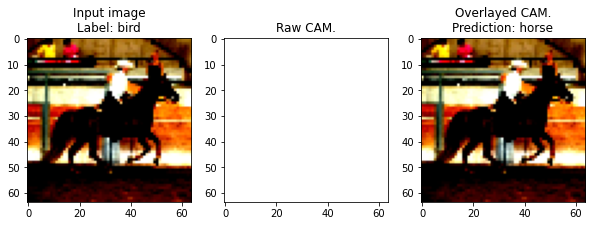

In [323]:
rand_idx = torch.randint(0, 20, size=[1]) # pick a random index from the test set

x = val_set[rand_idx][2] # test image
y = val_set[rand_idx][3] # associated test label

model2.eval()
scores = model2(x.unsqueeze(0)) # get the soft labels
probs = scores.data.squeeze()
probs, idx = probs.sort(0, True)

print('true class: ', classes[y])
print('predicated class: ', classes[idx[0]])

params = list(model2.nn.parameters())
weight = params[0].data

feature_maps = model2.layers(x.unsqueeze(0))
heatmap, _ = get_CAM(feature_maps, weight, idx[0])
    
plot_cam(x, heatmap, classes)

In [324]:
!pip install grad-cam

     |████████████████████████████████| 4.5 MB 12.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=ce014fb82f9cb051fecc7c84ba3b36aa84fc2b68eafcbf269b9c22dd7259ff7f
  Stored in directory: /home/rishabh/.cache/pip/wheels/30/ab/9c/53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam


tensor([8], device='cuda:0') 3


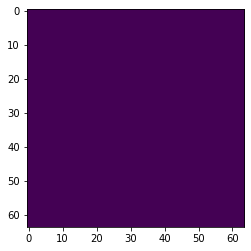

In [344]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model2.layers]
rand_idx = torch.randint(0, 100, size=[1]) # pick a random index from the test set
input_tensor = val_set[rand_idx][2].unsqueeze(0) # test image
y = val_set[rand_idx][3] # associated test label
scores = (model2(input_tensor.cuda()).argmax(1))
print (scores, y)


cam = GradCAM(model=model2, target_layers=target_layers, use_cuda=True)
targets = [ClassifierOutputTarget(y)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]
plt.imshow(grayscale_cam)
plt.show()
# visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=True)

In [42]:
def plot_tsne(d, title="", alpha=1, size=1):
    class_to_idx = {clas: idx for idx, clas in enumerate(d.keys())}
    idx_to_class = {idx: clas for idx, clas in enumerate(d.keys())}
    
    labels = []
    for clas, data in d.items():
        labels += [class_to_idx[clas]] * data.shape[0]
    labels = np.asarray(labels)
    
    data = np.concatenate(list(d.values()))
    data = data.reshape((data.shape[0], -1))
    pc = PCA(n_components=50).fit_transform(data)
    
    c = TSNE(n_components=2).fit_transform(pc)
    
    colors = cm.rainbow(np.linspace(0, 1, len(d.keys())))
    plt.title(title)
    for clas, color in zip(d.keys(), colors):
        idx = np.where(labels == class_to_idx[clas])[0]
        plt.scatter(c[idx][:,0], c[idx][:,1], label=clas, s=size, alpha=alpha, color=color)
    plt.legend(loc='best', markerscale=2)
    plt.show()

In [62]:
xs1 = []
xs2 = []
fs1 = []
fs2 = []
ys1 = []
ys2 = []
with torch.no_grad():
    for i, (x1, y1, x2, y2) in enumerate(val_loader):
        pred1, feats1 = model1(x1, return_feats=True)
        pred2, feats2 = model2(x2, return_feats=True)
        xs1.append(x1)
        xs2.append(x2)
        fs1.append(feats1)
        fs2.append(feats2)
        ys1.append(y1)
        ys2.append(y2)
data1 = torch.cat(xs1).numpy()
data2 = torch.cat(xs2).numpy()
feats1 = torch.cat(fs1).numpy()
labels1 = torch.cat(ys1).numpy()
feats2 = torch.cat(fs2).numpy()
labels2 = torch.cat(ys2).numpy()

In [123]:
def plot_tsne(feats, labels, pc=0, size=1, alpha=1):
    if pc > 0:
        feats = PCA(n_components=pc).fit_transform(feats)
    c = TSNE(n_components=2).fit_transform(feats)
    CLASSES = ["airplane", "car", "bird", "cat", "dog", "frog", "horse", "ship", "truck"]
    class_to_idx = {k: i for i, k in enumerate(CLASSES)}
    colors = cm.rainbow(np.linspace(0, 1, len(CLASSES)))
    plt.title("TSNE of MLP embeddings")
    for clas, color in zip(CLASSES, colors):
        idx = np.where(labels == class_to_idx[clas])[0]
        plt.scatter(c[idx][:,0], c[idx][:,1], label=clas, s=size, alpha=alpha, color=color)
    plt.legend(loc='best', markerscale=2)
    plt.show()

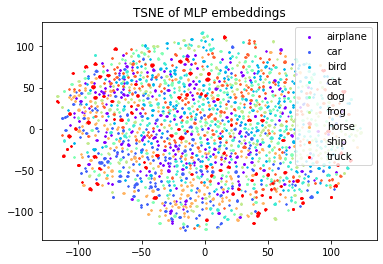

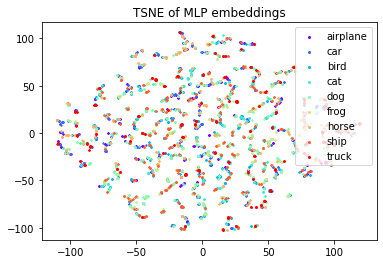

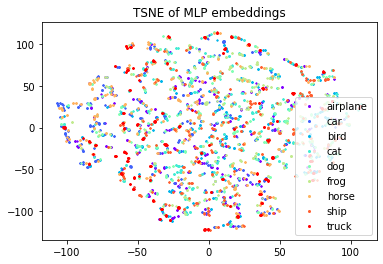

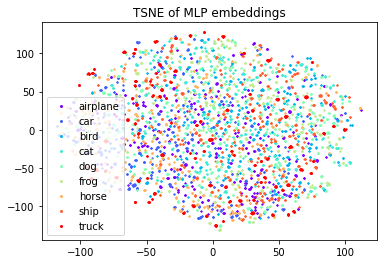

In [124]:
plot_tsne(feats1, labels1, pc=0)
plot_tsne(feats1, labels1, pc=2)
plot_tsne(feats1, labels1, pc=3)
plot_tsne(feats1, labels1, pc=10)

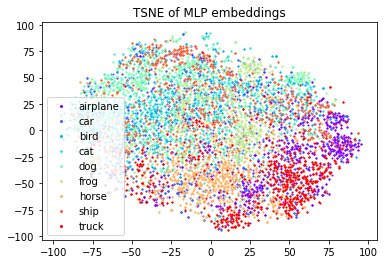

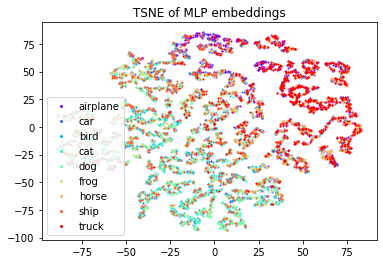

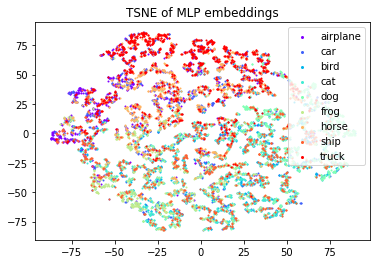

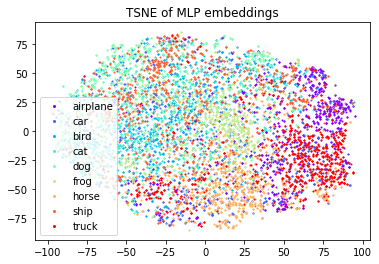

In [125]:
plot_tsne(feats2, labels2, pc=0)
plot_tsne(feats2, labels2, pc=2)
plot_tsne(feats2, labels2, pc=3)
plot_tsne(feats2, labels2, pc=10)

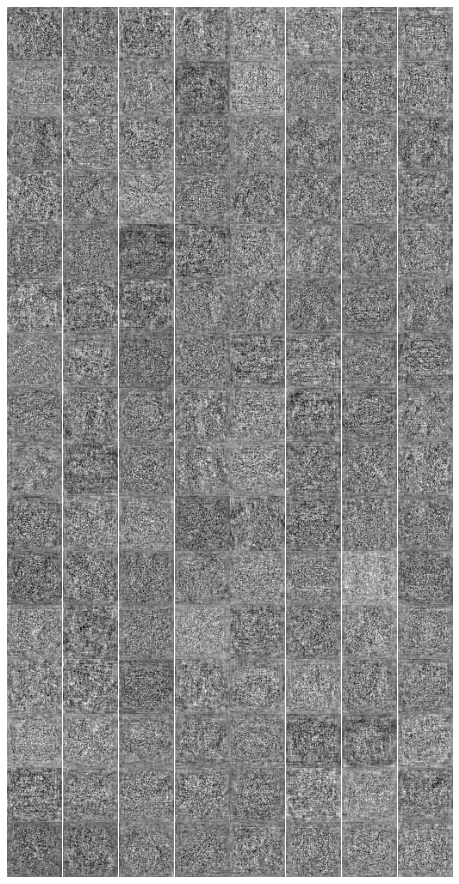

In [167]:
# fig, axs = plt.subplots(16, 32)
row, col = 16, 8
fig, ax = plt.subplots(row, col, figsize=(8,16))
plt.axis('off')
plt.subplots_adjust(hspace=0.001, wspace=0.001)
for r in range(row):
    for c in range(col):
        ax[r,c].axis('off')
        ax[r,c].set_xticks([])
        ax[r,c].set_yticks([])
        ax[r,c].imshow(model1.l1.weight.reshape((-1, 64, 64))[r*col + c, :, :].detach(), cmap='gray')
plt.show()

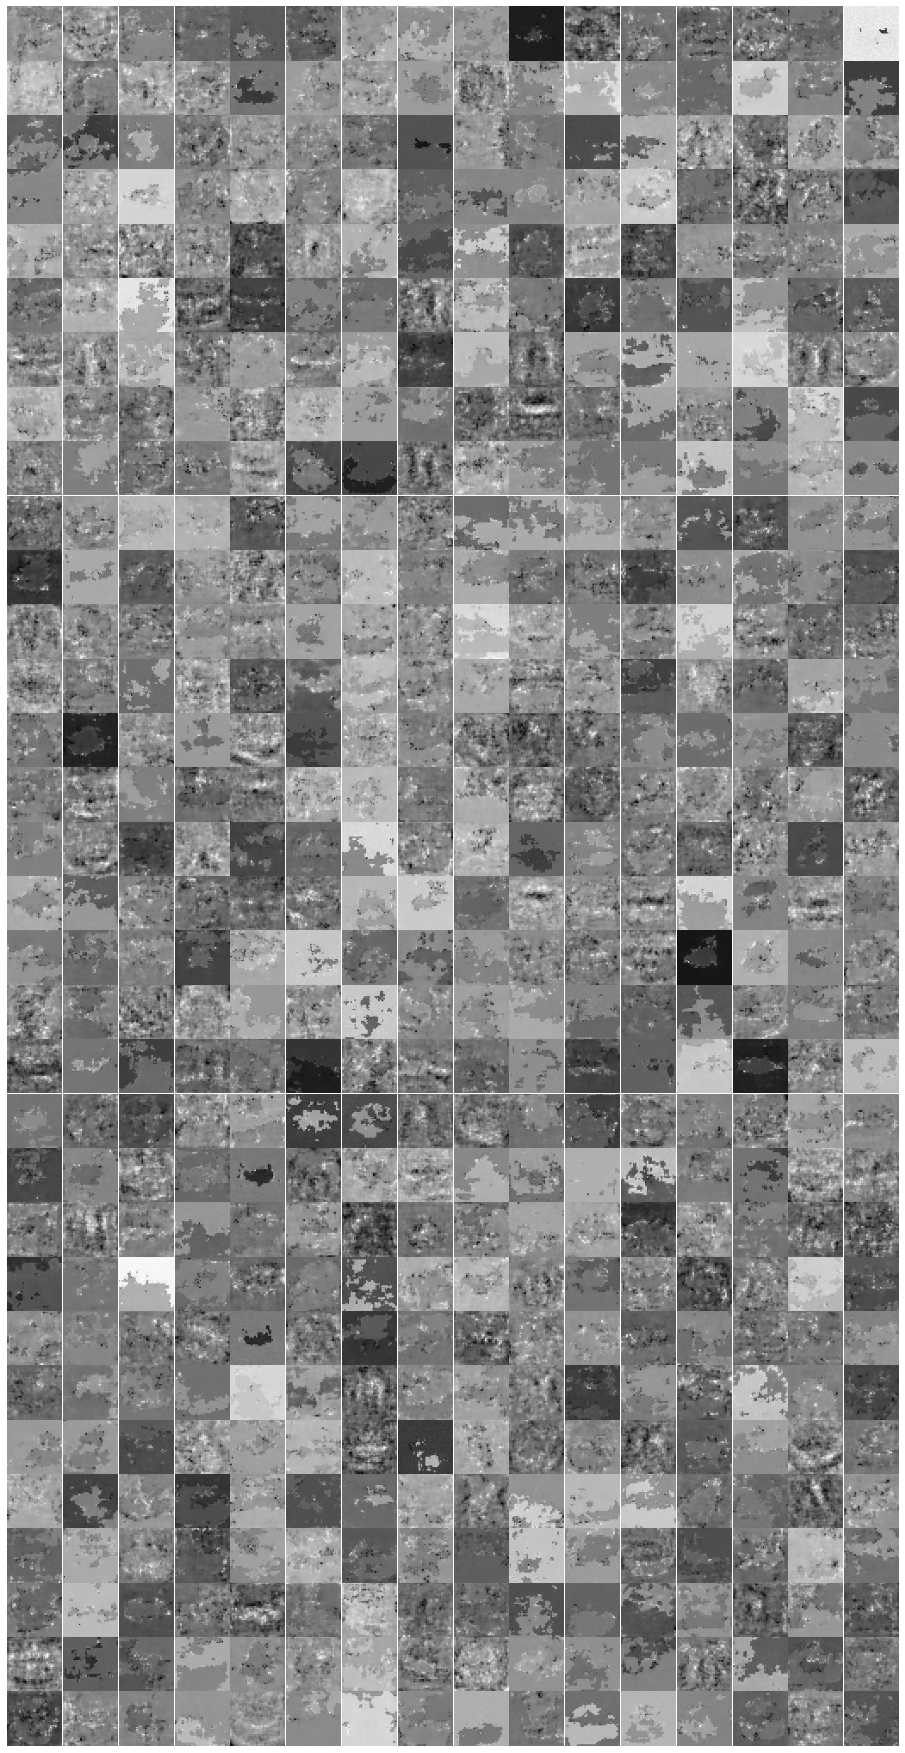

In [166]:
# fig, axs = plt.subplots(16, 32)
row, col = 32, 16
fig, ax = plt.subplots(row, col, figsize=(16,32))
plt.axis('off')
plt.subplots_adjust(hspace=0.001, wspace=0.001)
for r in range(row):
    for c in range(col):
        ax[r,c].axis('off')
        ax[r,c].set_xticks([])
        ax[r,c].set_yticks([])
        ax[r,c].imshow(model2.l1.weight.reshape((-1, 3, 64, 64))[r*col + c, 0, :, :].detach(), cmap='gray')
plt.show()